In [9]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import emd
import pandas as pd

In [44]:
# import data 
df = pd.read_parquet('/home/aevans/nwp_bias/src/machine_learning/data/clean_parquets/met_geo_cats/cleaned_rough_lstm_geo_met_cat_orange.parquet')
df.head()

,valid_time,time,station_ADDI,latitude_ADDI,longitude_ADDI,t2m_ADDI,sh2_ADDI,d2m_ADDI,r2_ADDI,u10_ADDI,...,26_aspect_WBOU,31_aspect_WBOU,33_aspect_WBOU,32_aspect_WBOU,34_aspect_WBOU,38_aspect_WBOU,std_elev_WBOU,variance_elev_WBOU,skew_elev_WBOU,med_dist_elev_WBOU
0,2018-01-01 03:00:00,2018-01-01 01:00:00,ADDI,42.045955,-77.218867,-19.199194,0.00068,-21.993216,76.800003,3.321081,...,0.0,0.0,0.0,0.0,0.0,0.0,33.799208,1132.538273,-0.117832,468.997986
1,2018-01-01 04:00:00,2018-01-01 02:00:00,ADDI,42.045955,-77.218867,-19.118689,0.00068,-21.918570,76.500000,3.298830,...,0.0,0.0,0.0,0.0,0.0,0.0,33.799208,1132.538273,-0.117832,468.997986
2,2018-01-01 05:00:00,2018-01-01 03:00:00,ADDI,42.045955,-77.218867,-19.439062,0.00065,-22.570868,73.800003,2.992857,...,0.0,0.0,0.0,0.0,0.0,0.0,33.799208,1132.538273,-0.117832,468.997986
3,2018-01-01 06:00:00,2018-01-01 04:00:00,ADDI,42.045955,-77.218867,-19.760291,0.00063,-22.821158,74.400002,3.115693,...,0.0,0.0,0.0,0.0,0.0,0.0,33.799208,1132.538273,-0.117832,468.997986
4,2018-01-01 07:00:00,2018-01-01 05:00:00,ADDI,42.045955,-77.218867,-19.860175,0.00062,-22.993704,74.099998,3.268302,...,0.0,0.0,0.0,0.0,0.0,0.0,33.799208,1132.538273,-0.117832,468.997986


In [12]:
len(df['t2m_ADDI'])

23618

In [56]:
# now we can estimate the IMFs for the signal
x = df['t2m_ADDI']
imf = emd.sift.sift(x)
print(imf.shape)

(23618, 10)


and, from the IMFs, compute the instantaneous frequency, phase and amplitude using the Normalised Hilbert Transform Method:

In [57]:
IP, IF, IA = emd.spectra.frequency_transform(imf, 23618, 'hilbert')

From the instantaneous frequency and amplitude, we can compute the Hilbert-Huang spectrum:

In [58]:
# Define frequency range (low_freq, high_freq, nsteps, spacing)
freq_range = (0.1, 10, 80, 'log')
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)

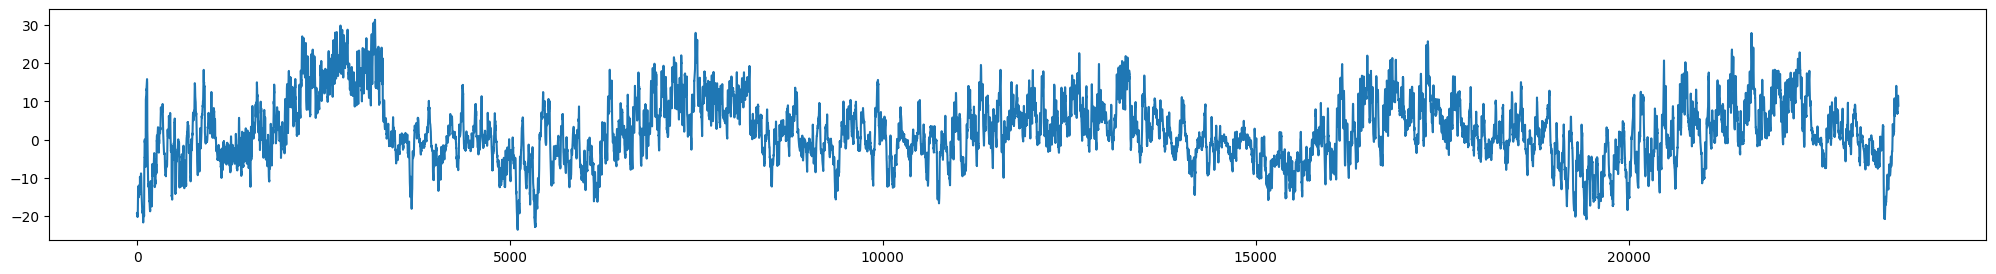

In [59]:
# visualize
fig = plt.figure(figsize=(25,3))
plt.plot(df['t2m_ADDI'])

Plot the IMFs

<Axes: xlabel='Time (samples)'>

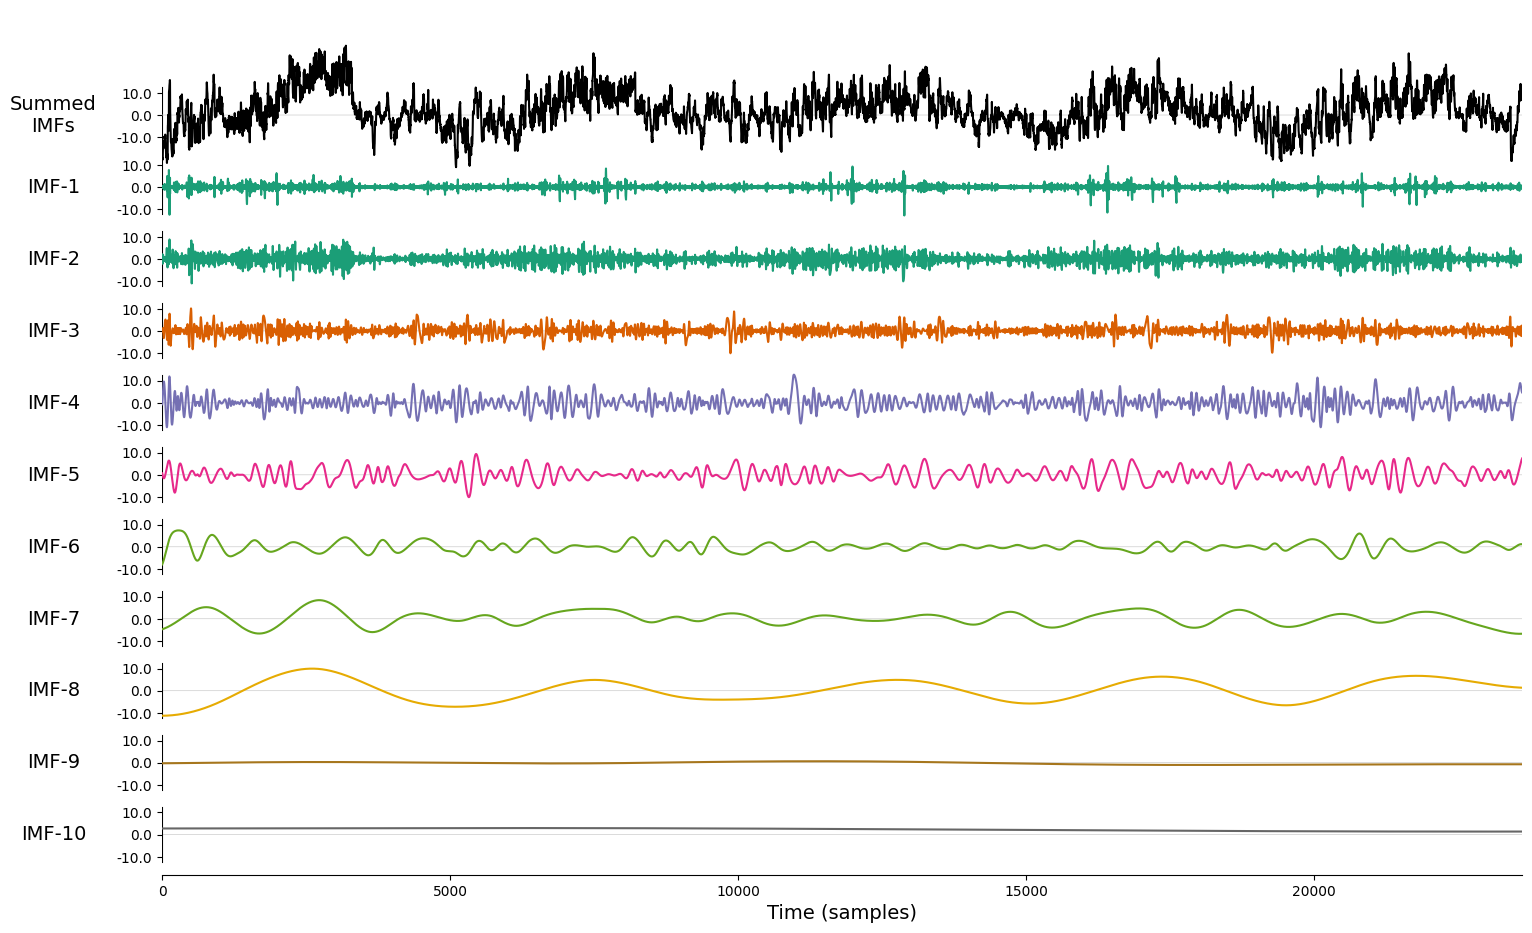

In [60]:
emd.plotting.plot_imfs(imf)

<Axes: title={'center': 'Hilbert-Huang Transform'}, xlabel='Time', ylabel='Frequency'>

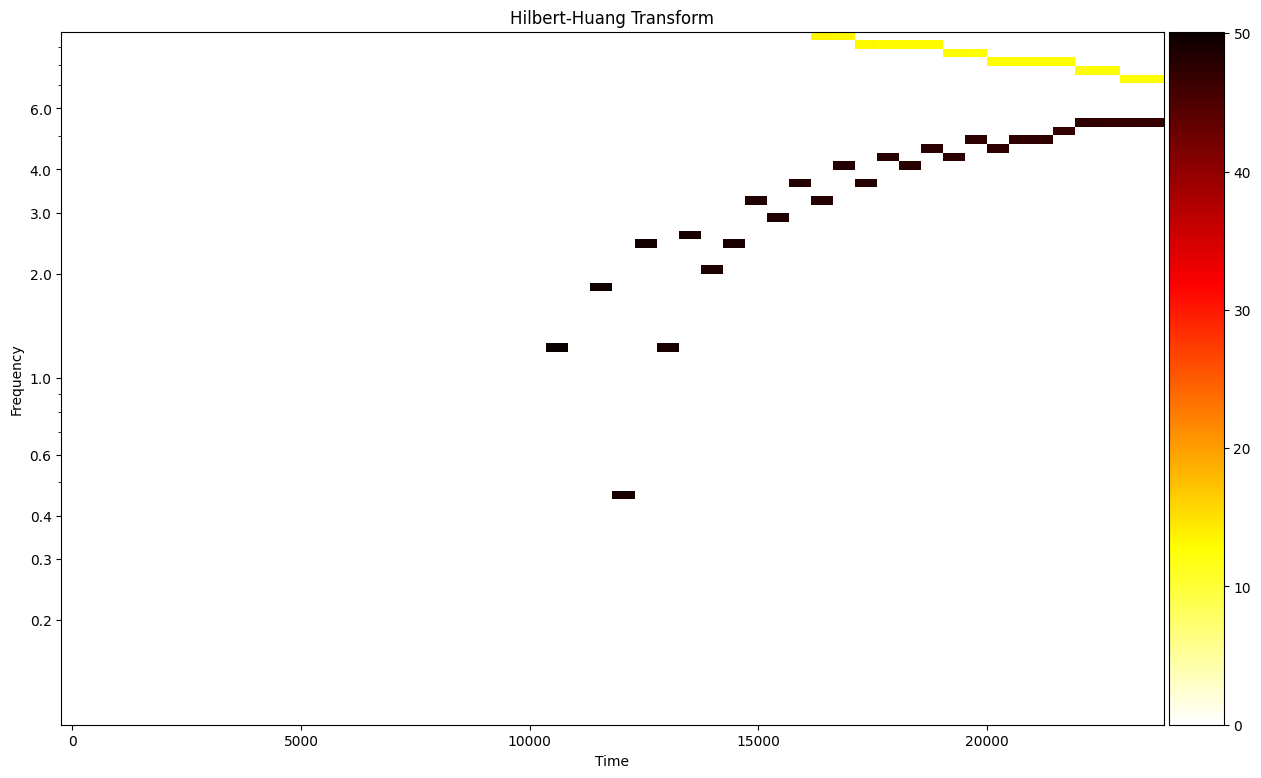

In [61]:
sample_rate = 23618
time_vect = np.linspace(0, sample_rate)
fig = plt.figure(figsize=(15, 9))
emd.plotting.plot_hilberthuang(hht, time_vect, f,
                               fig=fig, log_y=True)

# ensemble sifting 

In [62]:
imf_opts = {'sd_thresh': 0.05}

<Axes: xlabel='Time (samples)'>

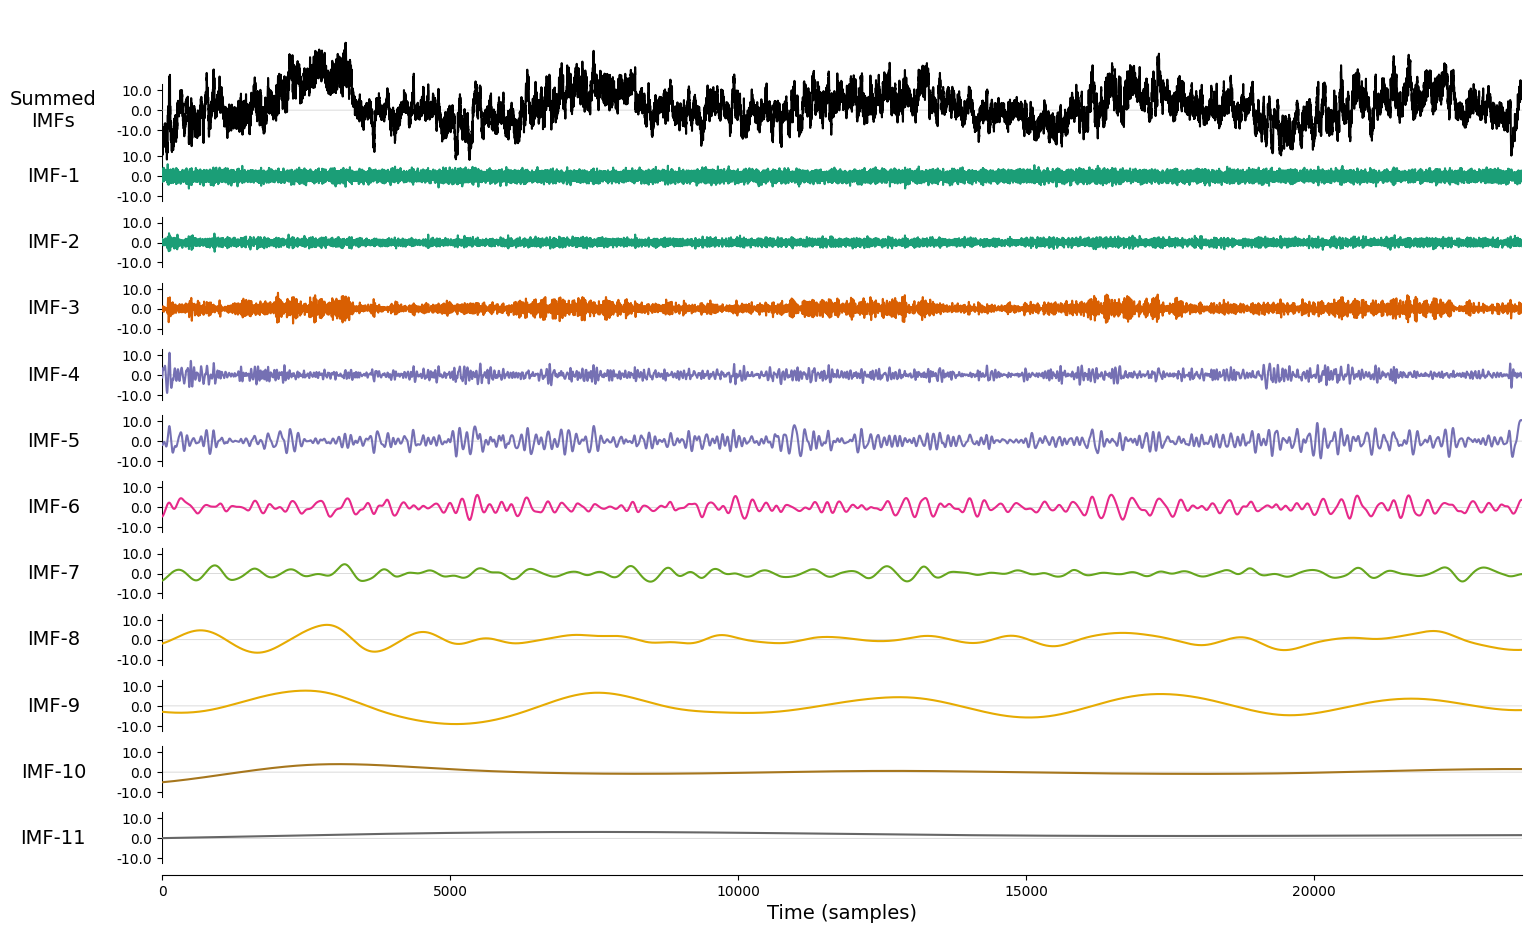

In [63]:
imf = emd.sift.ensemble_sift(x, nensembles=24, nprocesses=6, ensemble_noise=1, imf_opts=imf_opts)
emd.plotting.plot_imfs(imf)

In [64]:
imf.shape

(23618, 11)

and now the Hilbert-Huang transform of this decomposition

In [65]:
sample_rate = 23618

time_vect = np.linspace(0, sample_rate-.5)

<Axes: title={'center': 'Hilbert-Huang Transform'}, xlabel='Time', ylabel='Frequency'>

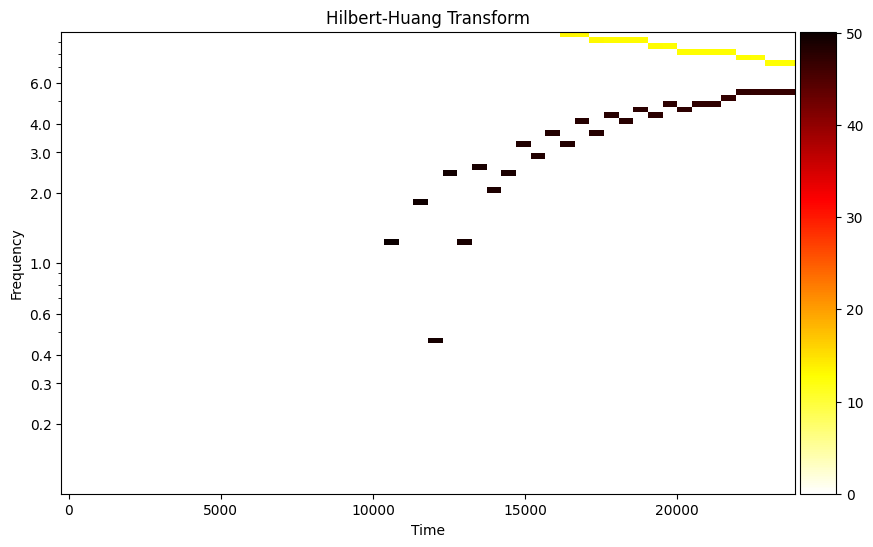

In [66]:
fig = plt.figure(figsize=(10, 6))
emd.plotting.plot_hilberthuang(hht, time_vect, f,
                               fig=fig, log_y=True)